In [2]:
import pickle
import lzma

with lzma.open('movie_data_movielens.xz', 'rb') as f:
    train_movie_ratings_list, test_movie_ratings_list = pickle.load(f)

with lzma.open('user_data_movielens.xz', 'rb') as f:
    train_user_ratings_list, test_user_ratings_list = pickle.load(f)

with lzma.open('params_2024-05-02 15:54:11.158311.xz', 'rb') as f:
    params = pickle.load(f)

In [4]:
# Unpack Variables
locals().update(params)

In [6]:
import numpy as np
from tqdm.notebook import tqdm

M = len(train_user_ratings_list)
N = len(train_movie_ratings_list)


user_biases = np.zeros((M))
item_biases = np.zeros((N))

# Hyperparameters
n_epochs = 100
lmb = 1
gamma = 0.1
tau = 1
k = 2

U = np.random.normal(loc=0.0, scale=1/np.sqrt(k), size=(M, k))
V = np.random.normal(loc=0.0, scale=1/np.sqrt(k), size=(N, k))


train_losses = []
train_rmses = []
test_losses = []
test_rmses = []


for i in tqdm(range(n_epochs)):
  for m in range(M):
    bias = 0
    item_counter = 0
    left = 0
    right = 0
    if train_user_ratings_list[m]:
      for (n, r) in train_user_ratings_list[m]:
        bias += lmb * (r - U[m].T.dot(V[n]) - item_biases[n])
        item_counter += 1
      bias = bias / (lmb * item_counter + gamma)
      user_biases[m] = bias

      for (n, r) in train_user_ratings_list[m]:
        left += V[n]*V[n].reshape(-1, 1)
        right += V[n]*(r - user_biases[m] - item_biases[n])
      U[m] = np.linalg.solve(lmb*left + tau*np.eye(k), lmb*right)


  for n in range(N):
    bias = 0
    user_counter = 0
    left = 0
    right = 0
    if train_movie_ratings_list[n]:
      for (m, r) in train_movie_ratings_list[n]:
        bias += lmb * (r - U[m].T.dot(V[n]) - user_biases[m])
        user_counter += 1
      bias = bias / (lmb * user_counter + gamma)
      item_biases[n] = bias

      for (m, r) in train_movie_ratings_list[n]:
        left += U[m]*U[m].reshape(-1, 1)
        right += U[m]*(r - user_biases[m] - item_biases[n])
      V[n] = np.linalg.solve(lmb*left + tau*np.eye(k), lmb*right)

  train_error_squared = 0
  test_error_squared = 0
  train_size = 0
  test_size = 0
  for m in range(M):
    
    for (n, r) in train_user_ratings_list[m]:
      train_error_squared += (r - (U[m].T.dot(V[n]) + user_biases[m] + item_biases[n]))**2
      train_size += 1

    for (n, r) in test_user_ratings_list[m]:
      test_error_squared += (r - (U[m].T.dot(V[n]) + user_biases[m] + item_biases[n]))**2
      test_size += 1

  train_loss = -0.5*lmb*train_error_squared - 0.5*gamma*np.sum(user_biases**2) - 0.5*gamma*np.sum(item_biases**2) - 0.5*tau*(np.einsum('ij, ij->', V, V) + np.einsum('ij, ij->', U, U))
  train_rmse = np.sqrt(1/train_size * train_error_squared)
  train_losses.append(-1*train_loss)
  train_rmses.append(train_rmse)

  test_loss = -0.5*lmb*test_error_squared - 0.5*gamma*np.sum(user_biases**2) - 0.5*gamma*np.sum(item_biases**2) - 0.5*tau*(np.einsum('ij, ij->', V, V) + np.einsum('ij, ij->', U, U))
  test_rmse = np.sqrt(1/test_size * test_error_squared)
  test_losses.append(-1*test_loss)
  test_rmses.append(test_rmse)

  print(f'train loss {round(-1*train_loss, 2)} test loss {round(-1*test_loss, 2)} train rmse {round(train_rmse, 4)} test rmse {round(test_rmse, 4)}')

  0%|          | 0/100 [00:00<?, ?it/s]

train loss 37023034.55 test loss 9945238.05 train rmse 0.8588 test rmse 0.8854
train loss 34945398.38 test loss 9519680.28 train rmse 0.834 test rmse 0.8652
train loss 33914246.48 test loss 9261336.71 train rmse 0.8215 test rmse 0.8529
train loss 33067516.25 test loss 9037567.7 train rmse 0.8111 test rmse 0.8422
train loss 32563411.59 test loss 8905390.78 train rmse 0.8049 test rmse 0.8359
train loss 32256503.71 test loss 8825311.27 train rmse 0.801 test rmse 0.8321
train loss 32057858.29 test loss 8774427.7 train rmse 0.7985 test rmse 0.8296
train loss 31921007.96 test loss 8739978.72 train rmse 0.7968 test rmse 0.8279
train loss 31817366.82 test loss 8713991.18 train rmse 0.7955 test rmse 0.8266
train loss 31731442.77 test loss 8692366.52 train rmse 0.7944 test rmse 0.8256
train loss 31655338.79 test loss 8672854.38 train rmse 0.7935 test rmse 0.8247
train loss 31585961.03 test loss 8654689.95 train rmse 0.7926 test rmse 0.8238
train loss 31523312.46 test loss 8638011.31 train rmse 0

KeyboardInterrupt: 

In [7]:
params = {
    'user_biases':user_biases,
    'item_biases':item_biases,
    'n_epochs':n_epochs, 
    'lmb':lmb, 
    'gamma':gamma, 
    'tau':tau, 
    'k': k, 
    'U':U, 
    'V': V, 
    'train_rmses':train_rmses, 
    'train_losses':train_losses,
    'test_rmses': test_rmses,
    'test_losses': test_losses,
}

In [8]:
import pickle
import lzma
import datetime;
 
# ct stores current time
ct = datetime.datetime.now()

with lzma.open(f'params_k={k}_{ct}.xz', 'wb') as f:
    pickle.dump(params, f, protocol=4)

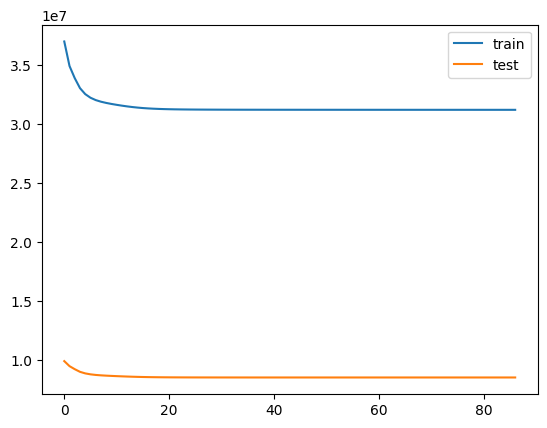

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

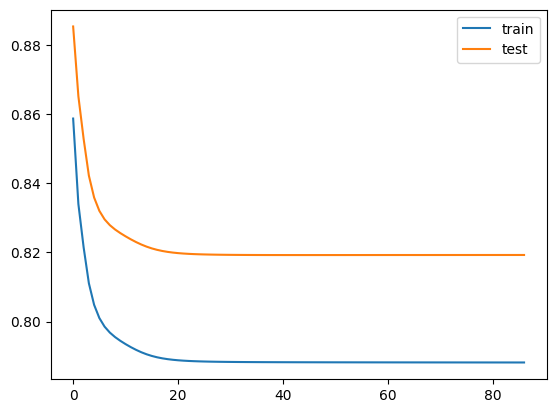

In [10]:
plt.plot(train_rmses, label='train')
plt.plot(test_rmses, label='test')
plt.legend()
plt.show()